# Quickstart: Building a GenAI powered Semantic Data Model with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic model. The semantic model captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is a Semantic Model?**

A semantic model is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

*   **Generate Semantic Model** → The unified layer that transforms fragmented datasets, creating the foundation for connected intelligence.
    *   **1.1 Profile and classify data** → Analyze your data sources to understand their structure, data types, and other characteristics.
    *   **1.2 Discover links & relationships among data** → Reveal meaningful connections (PK & FK) across fragmented tables.
    *   **1.3 Generate a business glossary** → Create business-friendly terms and use them to query data with context.
    *   **1.4 Enable Semantic search** → Intelligent search that understands meaning, not just keywords—making data more accessible across both technical and business users.
    *   **1.5 Visualize semantic model** → Get access to enriched metadata of the semantic model and visualize your data and relationships.
*   **Build Unified Data Products** → Simply pick the attributes across your data tables, and let the toolkit auto-generate queries with all the required joins, transformations, and aggregations using the semantic layer. When executed, these queries produce reusable data products.

Before you start, make sure you install the **Intugle Data Tools**:

In [ ]:
%pip install intugle

### Downloading the dataset

Make sure you download the sample data before getting started. We will be using a **professional basketball** dataset from BIRD SQL for this demo. You can run the following cell to download the datasets automatically:

In [ ]:
import os
import requests

raw_datasets='professional_basketball'
api_url = f"https://api.github.com/repos/Intugle/data-tools/contents/sample_data/{raw_datasets}"
local_dir = f"sample_data/{raw_datasets}"
os.makedirs(local_dir, exist_ok=True)

r = requests.get(api_url)
r.raise_for_status()

for item in r.json():
    if item["name"].endswith(".csv"):
        print(f"Downloading {item['name']}...")
        file_data = requests.get(item["download_url"])
        with open(os.path.join(local_dir, item["name"]), "wb") as f:
            f.write(file_data.content)

print("All CSV files downloaded successfully.")

> **Working with Remote URLs** : While `intugle` supports providing remote URLs (e.g., a raw GitHub file link) in the `path`, it is **not recommended for large datasets**. For best performance and stability, we recommend downloading files to your local filesystem first and providing a local path.

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).
*   `QDRANT_URL`: The URL of your Qdrant instance (e.g., `http://localhost:6333`).
*   `QDRANT_API_KEY`: Your API key for the Qdrant instance, if authorization is enabled.
*   `EMBEDDING_MODEL_NAME`: The embedding model to use. The format follows LangChain's conventions for initializing embedding models (e.g., `openai:ada`, `azure_openai:ada`).
*   `OPENAI_API_KEY`: Your OpenAI API key, required if you are using an OpenAI embedding model.
*   `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_ENDPOINT`, `OPENAI_API_VERSION`: Your Azure OpenAI credentials, required if you are using an Azure OpenAI embedding model.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [1]:
import os
from dotenv import load_dotenv

os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key

# Semantic Search Configuration (Optional)
os.environ["QDRANT_URL"] = "http://localhost:6333"
os.environ["QDRANT_API_KEY"] = ""  # if authorization is used
os.environ["EMBEDDING_MODEL_NAME"] = "openai:ada"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

# For Azure OpenAI models
os.environ["EMBEDDING_MODEL_NAME"] = "azure_openai:ada"
os.environ["AZURE_OPENAI_API_KEY"] = "your-azure-openai-api-key"
os.environ["AZURE_OPENAI_ENDPOINT"] = "your-azure-openai-endpoint"
os.environ["OPENAI_API_VERSION"] = "your-openai-api-version"

load_dotenv(override=True)

True

> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Building the Semantic Model

The `SemanticModel` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

In [2]:
def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "path": f"./sample_data/professional_basketball/{table_name}.csv",
        "type": "csv",
    }


table_names = [
    "awards_coaches",
    "awards_players",
    "coaches",
    "draft",
    "player_allstar",
    "players",
    "players_teams",
    "series_post",
    "teams",
]
datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `SemanticModel` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [3]:
from intugle import SemanticModel

# Initialize the semantic model
sm = SemanticModel(datasets, domain="Professional Basketball")

# Run the prediction
sm.build()

/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "SnowflakeConnectionConfig" shadows an attribute in parent "SchemaBase"
  warnings.warn(
/home/raphael/intugle/data-tools/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "DatabricksSQLConnectorConfig" shadows an attribute in parent "SchemaBase"
  warnings.warn(
/home/raphael/intugle/data-tools/.venv/lib/python3.12/sit

Found existing YAML for 'awards_coaches'. Checking for staleness.
awards_coaches loaded
Found existing YAML for 'awards_players'. Checking for staleness.
awards_players loaded
Found existing YAML for 'coaches'. Checking for staleness.
coaches loaded
Found existing YAML for 'draft'. Checking for staleness.
draft loaded
Found existing YAML for 'player_allstar'. Checking for staleness.
player_allstar loaded
Found existing YAML for 'players'. Checking for staleness.
players loaded
Found existing YAML for 'players_teams'. Checking for staleness.
players_teams loaded
Found existing YAML for 'series_post'. Checking for staleness.
series_post loaded
Found existing YAML for 'teams'. Checking for staleness.
teams loaded


Starting profiling and key identification stage...

Dataset 'awards_coaches' already profiled. Skipping.
Dataset 'awards_players' already profiled. Skipping.
Dataset 'coaches' already profiled. Skipping.
Dataset 'draft' already profiled. Skipping.
Dataset 'player_allstar' already profiled. Skipping.
Dataset 'players' already profiled. Skipping.
Dataset 'players_teams' already profiled. Skipping.
Dataset 'series_post' already profiled. Skipping.
Dataset 'teams' already profiled. Skipping.


Profiling and key identification complete.

Starting link prediction stage...

Dataset 'awards_coaches' already processed. Skipping analysis.
Dataset 'awards_players' already processed. Skipping analysis.
Dataset 'coaches' already processed. Skipping analysis.
Dataset 'draft' already processed. Skipping analysis.
Dataset 'player_allstar' already processed. Skipping analysis.
Dataset 'players' already processed. Skipping analysis.
Dataset 'players_teams' already processed. Skipping analysis.
Dataset 'series_post' already processed. Skipping analysis.
Dataset 'teams' already processed. Skipping analysis.
LinkPredictor initialized with datasets: ['awards_coaches', 'awards_players', 'coaches', 'draft', 'player_allstar', 'players', 'players_teams', 'series_post', 'teams']

--- Comparing 'awards_coaches' <=> 'awards_players' ---
[*] Langfuse tracing is active.
Found 1 potential link(s).

--- Comparing 'awards_coaches' <=> 'coaches' ---
[*] Langfuse tracing is active.
Found 1 potential link(s).

--- Comparing 'awards_coaches' <=> 'draft' ---
[*] Langfuse tracing is acti

Link prediction complete.

Starting business glossary generation stage...

Glossary for 'awards_coaches' already exists. Skipping.

Glossary for 'awards_players' already exists. Skipping.

Glossary for 'coaches' already exists. Skipping.

Glossary for 'draft' already exists. Skipping.

Glossary for 'player_allstar' already exists. Skipping.

Glossary for 'players' already exists. Skipping.

Glossary for 'players_teams' already exists. Skipping.

Glossary for 'series_post' already exists. Skipping.

Glossary for 'teams' already exists. Skipping.

Business glossary generation complete.

Initializing semantic search...


/home/raphael/intugle/data-tools/src/intugle/core/vector_store/qdrant.py:84: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
ERROR:intugle.core.vector_store.qdrant:AsyncQdrantService: Couldn't create collection, reason: All connection attempts failed


## 3. Accessing Enriched Metadata

Now that the semantic model is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `sm.datasets` dictionary:

In [4]:
players_dataset = sm.datasets['players']
players_dataset.profiling_df


,column_name,table_name,business_name,datatype_l1,datatype_l2,business_glossary,business_tags,count,null_count,distinct_count,uniqueness,completeness,sample_data
0,playerID,players,playerid,alphanumeric,dimension,A unique identifier assigned to each player to...,"[Player Identifier, Unique Player Reference, A...",5062,0,5062,1.000000,1.000000,"[durhapa01, edwarto01, hayesji01, crossje01, m..."
1,useFirst,players,usefirst,close_ended_text,dimension,Indicates the first name used by an individual...,"[Player First Name, Personal Identification, R...",5062,831,1223,0.241604,0.835836,"[Granville, Brandin, Ime, Marlon, Bryant, Devi..."
2,firstName,players,firstname,close_ended_text,dimension,The given name of an individual associated wit...,"[Player Identity, Personal Information, Roster...",5062,24,1270,0.250889,0.995259,"[Theron, Collis, Sherron, LaSalle, Ansley, DeM..."
3,middleName,players,middlename,close_ended_text,dimension,Indicates the secondary given name or initial ...,"[Player Identity, Personal Information, Name A...",5062,1816,914,0.180561,0.641249,"[Maxwell, Alfonso, H., Christian, Trevor James..."
4,lastName,players,lastname,close_ended_text,dimension,Specifies the family name or surname of an ind...,"[Player Identification, Player Name, Roster Ma...",5062,0,3072,0.606875,1.000000,"[Alvarez, Schwartz, Farbman, Ingerman, Dickau,..."
5,nameGiven,players,namegiven,close_ended_text,dimension,The first name or given name of an individual ...,"[Player First Name, Personal Identity, Roster ...",5062,5052,9,0.001778,0.001976,"[Jim, Robert, Ed, Mort, Willie, Thomas, nameGi..."
6,fullGivenName,players,fullgivenname,close_ended_text,dimension,Captures the complete first and last name of a...,"[Player Identification, Full Name, Personal In...",5062,5035,27,0.005334,0.005334,"[Joel Gregory Muleski, Hashim Thabit Manka, Ar..."
7,nameSuffix,players,namesuffix,close_ended_text,dimension,Distinguishes individuals who share the same f...,"[Player Name Hierarchy, Generational Identifie...",5062,4738,6,0.001185,0.064006,"[III, IV, Jr., nameSuffix, II, Sr.]"
8,nameNick,players,namenick,close_ended_text,dimension,A short or informal name used to identify an i...,"[Player Nickname, Identity Attribute, Informal...",5062,2354,1314,0.259581,0.534966,"[Mardy, Vince, Air Canada, Half-Man/Half-Amazi..."
9,pos,players,pos,close_ended_text,dimension,Indicates the designated playing position or r...,"[Player Position, Team Role Classification, Ba...",5062,182,14,0.002766,0.964046,"[F-G, G, C, F-C, F-C-G, G-F, F-G-C, F, C-F-G, ..."


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:

### Visualizing Relationships

The `SemanticModel` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:

In [5]:
sm.links

[PredictedLink(from_dataset='awards_coaches', from_columns=['year'], to_dataset='awards_players', to_columns=['year'], intersect_count=50, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.6666666666666666, from_uniqueness_ratio=0.819672131147541, to_uniqueness_ratio=0.04363001745200698, accuracy=1.0),
 PredictedLink(from_dataset='awards_coaches', from_columns=['year'], to_dataset='coaches', to_columns=['year'], intersect_count=50, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.7575757575757576, from_uniqueness_ratio=0.819672131147541, to_uniqueness_ratio=0.03907637655417407, accuracy=1.0),
 PredictedLink(from_dataset='awards_coaches', from_columns=['coachID'], to_dataset='players', to_columns=['playerID'], intersect_count=46, intersect_ratio_from_col=1.0, intersect_ratio_to_col=0.009087317265902806, from_uniqueness_ratio=0.7540983606557377, to_uniqueness_ratio=1.0, accuracy=1.0),
 PredictedLink(from_dataset='awards_coaches', from_columns=['year', 'lgID'], to_dataset='team

You can also visualize these relationships as a graph. In case you run into an error, make sure you install/upgrade your ipykernel package:
> %pip install --upgrade ipykernel

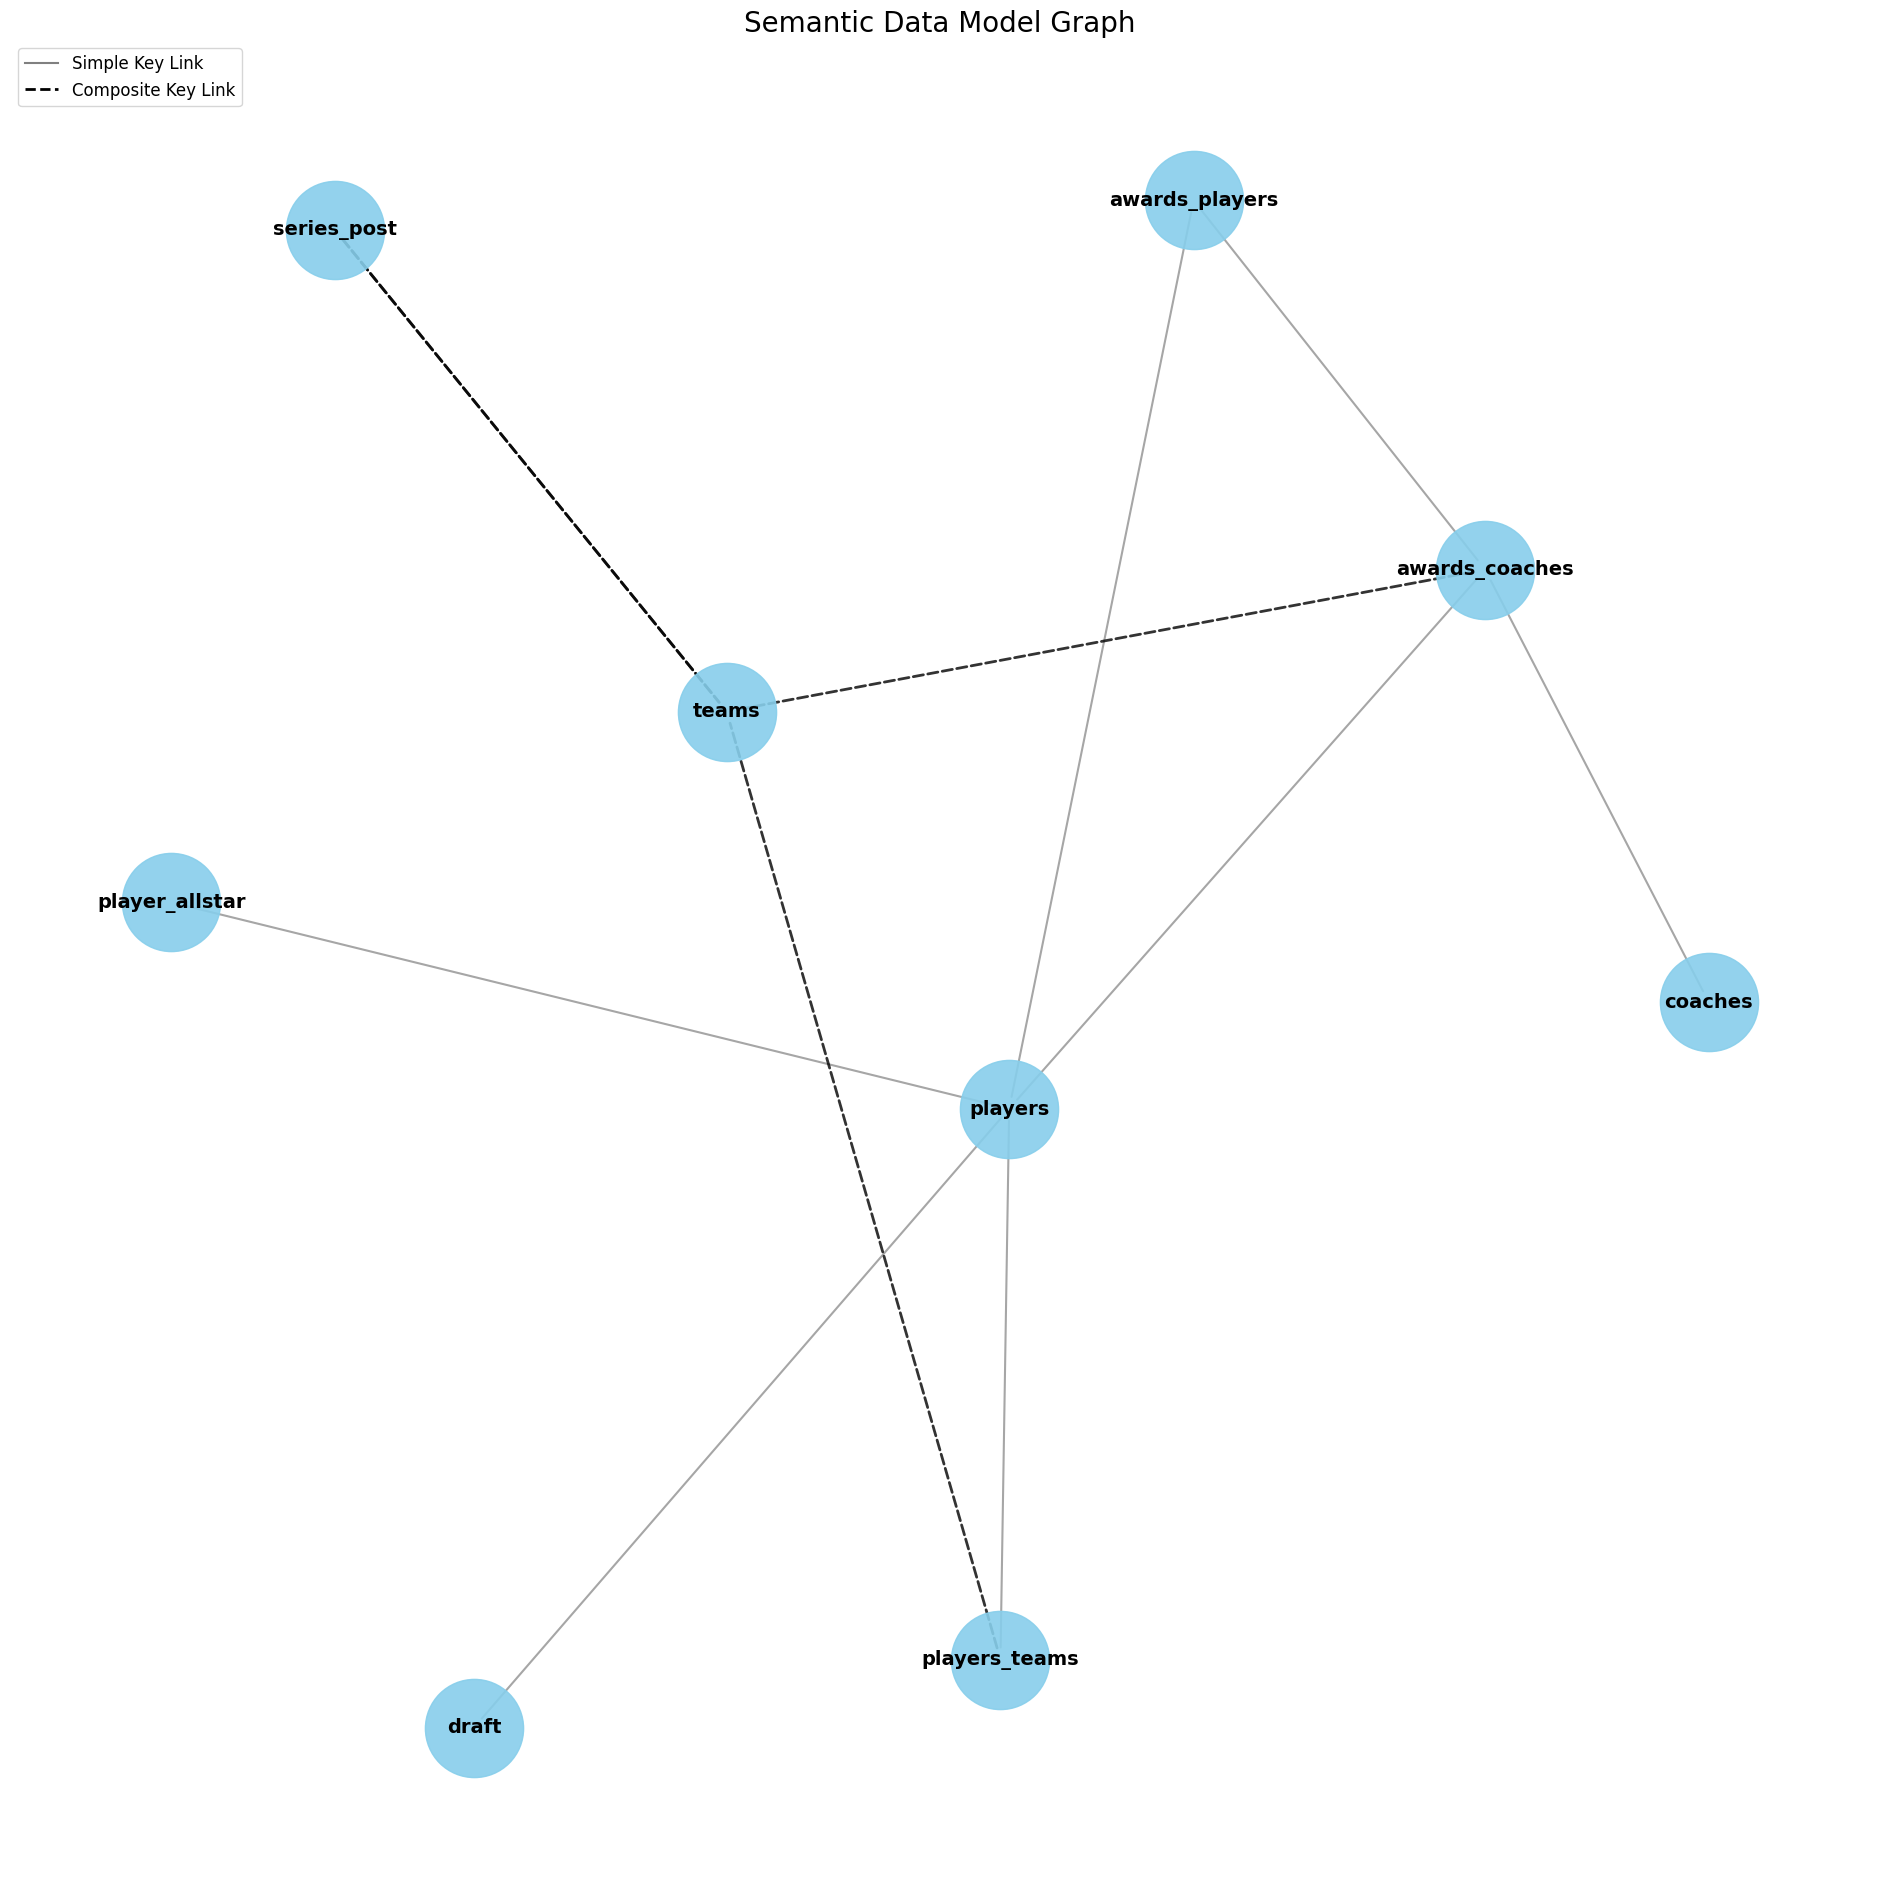

In [6]:
sm.visualize()  # To visualize the relationships as a graph

## 4. The Semantic Layer

The SemanticModel results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory under `intugle/models`. You can configure this path by setting the `MODELS_DIR` environment variable.

## 5. Semantic Search

The semantic search feature allows you to search for columns in your datasets using natural language. 

> **Note:** To use this feature, you need to have a running Qdrant instance and an OpenAI API key. Please refer to the [README.md](README.md) for detailed setup instructions.
>
> **Google Colab Users:** If you are running this notebook in Google Colab, you may not be able to connect to a local Qdrant instance running in Docker. In this case, you will need to use a remotely hosted Qdrant server.
>
> **Current Limitation:** Currently, the semantic search feature requires an OpenAI or Azure OpenAI key as it is tightly coupled with Ada embeddings. We are actively working on decoupling this.

Once you have built the semantic model, you can use the `search` method to perform a semantic search. The search function returns a pandas DataFrame containing the search results, including the column's profiling metrics, category, table name, and table glossary.

In [10]:
# Perform a semantic search
search_results = sm.search("player education")

# View the search results
search_results

/home/raphael/intugle/data-tools/src/intugle/core/vector_store/qdrant.py:84: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/intugle/data-tools/src/intugle/core/vector_store/qdrant.py:84: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/intugle/data-tools/src/intugle/core/semantic_search/semantic_search.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_embedding_result_glossary["score"] = late_embedding_result_glossary["score"] / len(late_vector)


,column_id,score,relevancy,column_name,column_glossary,column_tags,category,table_name,table_glossary,uniqueness,completeness,count,null_count,distinct_count,sample_data
0,players.hsCountry,0.950379,RelevancyCate,hsCountry,Indicates the country associated with a player...,"[High School Country, Player National Origin, ...",dimension,players,"Captures detailed personal, physical, and care...",0.010273,0.848874,5062,765,52,"[ESP, JAM, SRB, USa, JPN, ISV, FIN, KOR, VEN, ..."
1,players.hsState,0.950379,RelevancyCate,hsState,Indicates the state or states associated with ...,"[High School Location, Player Geographic Backg...",dimension,players,"Captures detailed personal, physical, and care...",0.037139,0.835243,5062,834,188,"[NE, FL / NY, NH / NC, CT / NY, NC / FL, NY/VA..."
2,players.highSchool,0.950379,RelevancyCate,highSchool,Indicates the secondary education institution ...,"[Player Education Background, High School Affi...",dimension,players,"Captures detailed personal, physical, and care...",0.506124,0.847294,5062,773,2562,"[Messmer, Mount Dora, Cardozo, Southampton, Ch..."
3,players.college,0.950378,RelevancyCate,college,Educational institution where the player recei...,"[Educational Institution, Player Background, T...",dimension,players,"Captures detailed personal, physical, and care...",0.135717,0.964836,5062,178,687,"[Jacksonville State, North Carolina College, A..."
4,players.collegeOther,0.930343,RelevancyCate,collegeOther,Indicates the educational institution attended...,"[Player Education Background, College Affiliat...",dimension,players,"Captures detailed personal, physical, and care...",0.123469,0.168708,5062,4208,625,"[Kentucky?, Allan Hancock JC, Holy Cross, Wall..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,coaches.post_wins,0.800746,Relevanc,post_wins,Tracks the number of games won by a coach duri...,"[Postseason Performance, Coaching Success, Pla...",measure,coaches,Tracks performance metrics and tenure details ...,0.010065,0.976317,1689,40,17,"[8, 10, 14, 16, 1, 13, 2, 0, 7, 12]"
153,coaches.lost,0.799074,RelevancyCate,lost,Reflects the number of games a coach's team di...,"[Games Lost, Coaching Performance, Team Outcomes]",measure,coaches,Tracks performance metrics and tenure details ...,0.042629,0.994671,1689,9,72,"[35, 15, 2, 41, 4, 56, 1, 43, 47, 34]"
154,players_teams.PostfgMade,0.798574,RelevancyCate,PostfgMade,Tracks the number of field goals successfully ...,"[Postseason Field Goals Made, Player Performan...",measure,players_teams,"Tracks players' participation, performance sta...",0.009221,1.000000,23751,0,219,"[4, 17, 138, 141, 132, 67, 204, 134, 52, 40]"
155,teams.lost,0.796820,RelevancyCate,lost,Reflects the total number of games a team has ...,"[Team Performance, Games Lost, Season Statistics]",measure,teams,Captures detailed information about basketball...,0.047526,1.000000,1536,0,73,"[25, 20, 67, 51, 56, 1, 62, 50, 60, 30]"


## 6. Data Product Creation

The semantic layer serves as a foundation for the DataProduct, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

In [11]:
data_product_config = \
{
  "name": "player_performance_dashboard",
  "fields": [
    {
      "id": "players.firstName",
      "name": "first_name"
    },
    {
      "id": "players.lastName",
        "name": "last_name"
      },
      {
        "id": "players.pos",
        "name": "position"
      },
      {
        "id": "players.birthDate",
        "name": "birth_date"
      },
      {
        "id": "players.college",
        "name": "college"
      },
      {
        "id": "awards_players.award",
        "name": "award"
      },
      {
        "id": "awards_players.year",
        "name": "award_year"
      },
      {
        "id": "players_teams.GP",
        "name": "games_played",
        "category": "measure",
        "measure_func": "sum"
      },
      {
        "id": "players_teams.points",
        "name": "points_per_game",
        "category": "measure",
        "measure_func": "average"
      },
      {
        "id": "players_teams.rebounds",
        "name": "rebounds_per_game",
        "category": "measure",
        "measure_func": "average"
      },
      {
        "id": "players_teams.assists",
        "name": "assists_per_game",
        "category": "measure",
        "measure_func": "average"
      },
      {
        "id": "players_teams.PostGP",
        "name": "postseason_games_played",
        "category": "measure",
        "measure_func": "sum"
      },
      {
        "id": "players_teams.PostPoints",
        "name": "postseason_points_per_game",
        "category": "measure",
        "measure_func": "average"
      },
      {
        "id": "player_allstar.games_played",
        "name": "allstar_games_played",
        "category": "measure",
        "measure_func": "sum"
      },
      {
        "id": "player_allstar.points",
        "name": "allstar_points_per_game",
        "category": "measure",
        "measure_func": "average"
      }
    ],
    "filter": {
      "selections": [
        {
          "id": "players.playerID",
          "values": ["jordami01"]
        }
      ]
    }
  }

Now, let's use the `DataProduct` to generate the data product:

In [12]:
from intugle import DataProduct

# Create a DataProduct
dp = DataProduct()

# Generate the data product
data_product = dp.build(data_product_config)

data_product.to_df()

Found existing YAML for 'draft'. Checking for staleness.
draft loaded
Found existing YAML for 'awards_players'. Checking for staleness.
awards_players loaded
Found existing YAML for 'coaches'. Checking for staleness.
coaches loaded
Found existing YAML for 'series_post'. Checking for staleness.
series_post loaded
Found existing YAML for 'player_allstar'. Checking for staleness.
player_allstar loaded
Found existing YAML for 'awards_coaches'. Checking for staleness.
awards_coaches loaded
Found existing YAML for 'teams'. Checking for staleness.
teams loaded
Found existing YAML for 'players'. Checking for staleness.
players loaded
Found existing YAML for 'players_teams'. Checking for staleness.
players_teams loaded
player_performance_dashboard loaded


,first_name,last_name,position,birth_date,college,award,award_year,games_played,points_per_game,rebounds_per_game,assists_per_game,postseason_games_played,postseason_points_per_game,allstar_games_played,allstar_points_per_game
0,Michael,Jordan,G-F,1963-02-17,North Carolina,All-NBA First Team,1997,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
1,Michael,Jordan,G-F,1963-02-17,North Carolina,All-Defensive First Team,1996,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
2,Michael,Jordan,G-F,1963-02-17,North Carolina,All-Defensive First Team,1992,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
3,Michael,Jordan,G-F,1963-02-17,North Carolina,All-NBA First Team,1991,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
4,Michael,Jordan,G-F,1963-02-17,North Carolina,All-NBA Second Team,1984,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
5,Michael,Jordan,G-F,1963-02-17,North Carolina,Most Valuable Player,1995,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
6,Michael,Jordan,G-F,1963-02-17,North Carolina,All-NBA First Team,1986,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
7,Michael,Jordan,G-F,1963-02-17,North Carolina,Finals MVP,1997,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
8,Michael,Jordan,G-F,1963-02-17,North Carolina,All-Defensive First Team,1989,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846
9,Michael,Jordan,G-F,1963-02-17,North Carolina,Finals MVP,1990,15008.0,2152.8,444.8,375.533333,2506.0,399.133333,210.0,20.153846


The `build` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:

In [13]:
# The generated SQL query
data_product.sql_query

'SELECT "players"."firstName" as first_name, "players"."lastName" as last_name, "players"."pos" as position, "players"."birthDate" as birth_date, "players"."college" as college, "awards_players"."award" as award, "awards_players"."year" as award_year, sum("players_teams"."GP") as games_played, avg("players_teams"."points") as points_per_game, avg("players_teams"."rebounds") as rebounds_per_game, avg("players_teams"."assists") as assists_per_game, sum("players_teams"."PostGP") as postseason_games_played, avg("players_teams"."PostPoints") as postseason_points_per_game, sum("player_allstar"."games_played") as allstar_games_played, avg("player_allstar"."points") as allstar_points_per_game FROM player_allstar LEFT JOIN players ON "players"."playerID" = "player_allstar"."playerID" LEFT JOIN players_teams ON "players"."playerID" = "players_teams"."playerID" LEFT JOIN awards_players ON "players"."playerID" = "awards_players"."playerID" WHERE ("players"."playerID" IN (\'jordami01\',)) GROUP BY 

## Conclusion

You've learned how to:

*   Configure your LLM provider and Embeddings provider.
*   Build a semantic model using the `SemanticModel`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Perform semantic search on your semantic model.
*   Generate data products from the semantic layer using the `DataProduct`.

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.